
# Diseño de software para cómputo científico

----

## Unidad 4: Optimización, paralelismo, concurrencia y cómputo distribuido en alto nivel.


## Agenda de la Unidad 4

- Multithreading, Paralelismo, Concurrencia.
- Optimización y Optimización prematura. Cuellos de botella, Legibilidad vs. Optimización.
- Profiling.
- Compiladores justo a tiempo (numba).
- **Cómputo distribuido con Dask.**


## Los imports

In [8]:
%matplotlib inline
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from bokeh.plotting import output_notebook
output_notebook()

from libs.dask_data_creation import generate_presentation_data
generate_presentation_data()

Loading BokehJS ...

Removing old data
Generating dask dataframe data sample...
Removing old data
Generating dask bag data sample...


## Dask

![image.png](imgs/collections-schedulers.png)

- Es una libreria para computacion paralela en Python.
- Esta compuesta por dos grandes partes:

    1. Por un lado tenemos la interfaz del usuario. Se usa para definir un grafo de tareas a ser ejecutadas. 
    2. Schedulers: son los encargados de ejecutar muchas funciones python en forma paralela


## Dask

#### Por qué?

* API conocida
* Se puede usar local como en cluster
* Se integra con el ecosistema Python
* Soporta aplicaciones complejas
* Tiene herramientas de diagnostico bastante útiles.
* Installen con:

```bash
$ pip install dask[complete] graphviz bokeh
```


## Dask Array

<div style="float: left; margin: 30px;"><img src="imgs/dask-array-black-text.svg" width="600" align="middle"></div>


## Dask Array

In [1]:
import dask.array as da

In [2]:
x = da.arange(25, chunks=5)
x

dask.array<arange, shape=(25,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

In [3]:
y = x ** 2
y

dask.array<pow, shape=(25,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

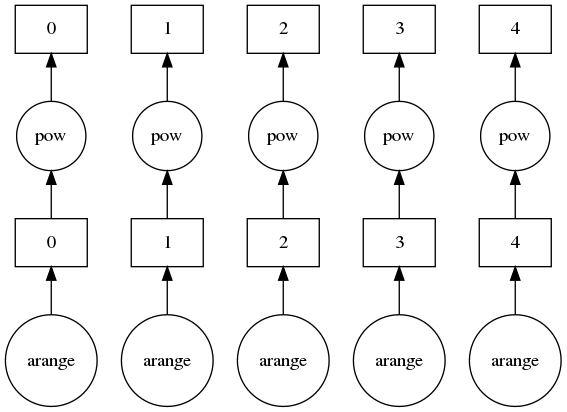

In [4]:
y.visualize()

In [5]:
y.compute()

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

In [6]:
y.compute(scheduler='processes')

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

### Numpy vs Dask


In [9]:
%%time
np_data = np.random.normal(1, size=(20_000, 20_000))
np_data[::50].mean(axis=0)
print("Se usaron {:.2f} GB de RAM".format(np_data.nbytes / 1024**3))

Se usaron 2.98 GB de RAM
CPU times: user 15.7 s, sys: 580 ms, total: 16.2 s
Wall time: 16.2 s


In [10]:
%%time
da_data = da.random.normal(1, size=(20_000, 20_000), 
                           chunks=(1_000, 1_000))
da_data[::50].mean(axis=0).compute()

CPU times: user 32.2 s, sys: 146 ms, total: 32.3 s
Wall time: 4.27 s


### Diagnostics

In [11]:
from dask.diagnostics import (Profiler, ResourceProfiler, 
                              visualize, ProgressBar)

ProgressBar().register()

In [12]:
with Profiler() as prof, ResourceProfiler(dt=0.2) as rprof:
    da_data[::50].mean(axis=0).compute()
visualize([prof, rprof], save=False);

[########################################] | 100% Completed |  4.4s


## Dask Bag


In [ ]:
import json
import dask.bag as db

data = db.read_text('db_data/*.json.gz')
data.take(1)

In [ ]:
data = data.map(json.loads)
data.take(1)

In [ ]:
promedio = data.pluck('duration').mean()
promedio.visualize()

In [ ]:
promedio.compute()

## Dask Dataframe

<div style="float: left; margin: 30px;"><img src="imgs/dask-dataframe.svg" width="300" align="middle"></div>


**¿Cuando usarlo?**

* El dataset no entra en memoria
* Aprovechar todos los cores para calculos complejos
* Distribuir operaciones comunes de pandas

**¿Cuando NO usarlo?**

* Los datos entran en memoria
* Los datos no son tabulares
* Se necesita hacer algún calculo no estandar

In [ ]:
import dask.dataframe as dd

df = dd.read_csv('dd_data/*.csv.gz', compression='gzip', blocksize=None)
df

In [ ]:
%%time
promedios = df.groupby('month').duration.mean()
promedios.compute()

In [ ]:
%%time
df_pandas = df.compute()
df_pandas.groupby('month').duration.mean()

## Delayed

Permite la creación de grafos modificando levemente el código Python original

In [ ]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

output = []
for x in range(1, 6):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)
total

In [ ]:
from dask import delayed

@delayed
def inc(x):
    return x + 1

output = []
for x in range(1, 6):
    a = inc(x)
    b = delayed(double)(x)
    c = delayed(add)(a, b)
    output.append(c)

total = delayed(sum)(output)
total.visualize()

In [ ]:
with Profiler() as prof:
    print(total.compute())
visualize([prof], save=False);

## Referencias

- Charla original: https://github.com/arielrossanigo/procesando_datos_en_paralelo_con_dask de **Ariel Rossanigo**
- Video de la charla original: https://www.youtube.com/watch?v=APcUJOVrFlk

